In [ ]:
from transformers import BertModel, BertTokenizer, GPT2Model, GPT2Tokenizer, BertConfig, GPT2Config
from datasets import load_dataset
import torch
import pandas as pd
import tqdm
from utils import variance_norms, isometry_gap


# Other models and tokenizers can be added to these dictionaries
MODEL_CLASSES = {
    'BERT': (BertModel, BertTokenizer, BertConfig, 'bert-base-uncased'),
    'GPT2': (GPT2Model, GPT2Tokenizer, GPT2Config, 'gpt2'),
}

# Check if CUDA is available, and if so, set device to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ModelHook:
    def __init__(self, model):
        self.layer_names_and_outputs = []
        self.register_hooks(model)

    def register_hooks(self, module, name_prefix=''):
        for name, submodule in module.named_children():
            full_name = name_prefix + '.' + name if name_prefix else name
            submodule.register_forward_hook(self.hook(full_name))
            self.register_hooks(submodule, full_name)

    def hook(self, name):
        def hook_fn(module, input, output):
            try:
                while not isinstance(input, torch.Tensor):
                    input = input[0]
                while not isinstance(output, torch.Tensor):
                    output = output[0]
                self.layer_names_and_outputs.append((name, input, output))
            except:
                pass
        return hook_fn


def prepare_batch_texts(dataset, batch_size, batch_index):
    start_idx = batch_index * batch_size
    end_idx = start_idx + batch_size
    return [item[:512] for item in dataset['train'][start_idx:end_idx]['text']]


def analyze_layer(layer_names_and_outputs, model_name):
    layer_index = {'GPT2': 1, 'BERT': 2}
    layer_index = layer_index[model_name]
    ln_name = {'GPT2': 'ln', 'BERT': 'LayerNorm'}
    ln_name = ln_name[model_name]
    df = []
    for k, input, output in layer_names_and_outputs:
        try:
            ig1, ig2 = isometry_gaps(input, output)
            layer = int(k.split('.')[layer_index])
            if ln_name in k:
                df.append({'li': len(df), 'layer': layer, 'name': k.replace(ln_name, 'Add'), 'iso_gap': ig1})
            df.append({'li': len(df), 'layer': layer, 'name': k, 'iso_gap': ig2})
        except:
            pass
    return df


def isometry_gaps(input, output):
    input_flat = input.flatten(0, 1)
    output_flat = output.flatten(0, 1)
    print('input shape = ', input.shape, ' input_flat shape = ', input_flat.shape)
    # input_flat = input_flat - input_flat.mean(dim=1, keepdim=True)
    # output_flat = output_flat - output_flat.mean(dim=1, keepdim=True)
    return isometry_gap(input_flat @ input_flat.t()).item(), isometry_gap(output_flat @ output_flat.t()).item()

def run_experiment(config):
    model_class, tokenizer_class, model_config, model_identifier = MODEL_CLASSES[config['model_name']]
    model_identifier
    if config['pretrained']:
        model = model_class.from_pretrained(model_identifier)
    else:
        model = model_class(model_config())
    model.to(device)  # Move the model to the chosen device

    tokenizer = tokenizer_class.from_pretrained(model_identifier)
    if config['model_name']=='GPT2':
        tokenizer.pad_token = tokenizer.eos_token

    hook = ModelHook(model)

    # Load Simple English Wikipedia dataset
    wiki_dataset = load_dataset('wikipedia', '20220301.simple')

    torch.no_grad()
    model.train()

    all_results = []

    for bi in tqdm.trange(config['num_batches']):
        batch_texts = prepare_batch_texts(wiki_dataset, config['batch_size'], bi)
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}  # Move input tensors to the chosen device
        hook.layer_names_and_outputs = []
        outputs = model(**inputs)
        df = analyze_layer(hook.layer_names_and_outputs, model_name=config['model_name'])
        all_results.extend(df)

    all_results = pd.DataFrame(all_results)
    # all_results['module_name'] = all_results.name.apply(lambda x: x.split('.')[-1])
    return all_results

if __name__ == "__main__":
    config = {
        'batch_size': 1,
        'num_batches': 10,
        'model_name': 'GPT2', # BERT or 'GPT2'
        'pretrained': True,
    }
results = run_experiment(config)

<ipython-input-5-7b92ea9fce6e>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df3 = df2.loc[df2.name.str.contains('ln')].groupby(['li']).mean().reset_index()


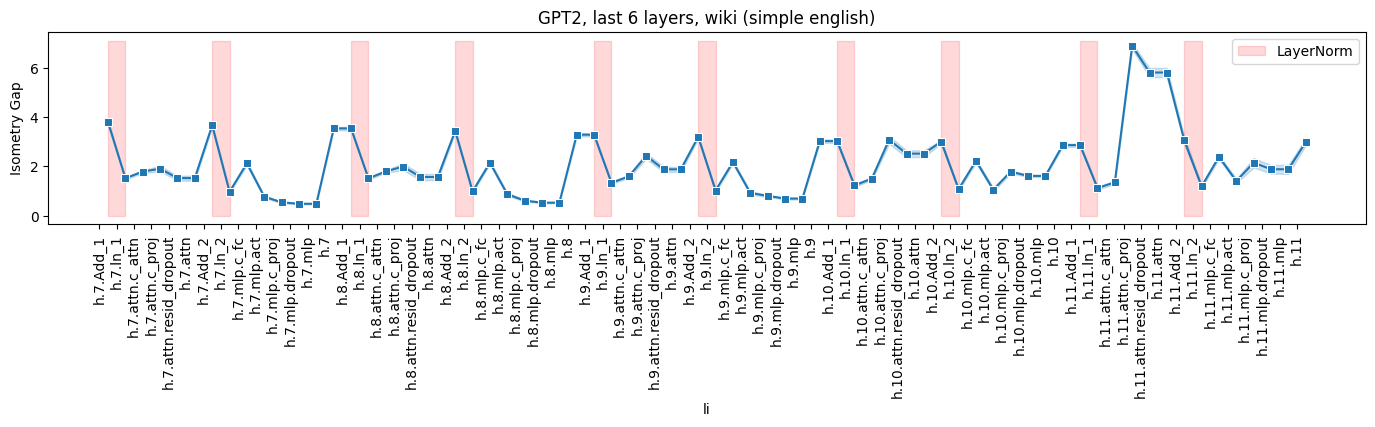

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(17,2.5))
df2 = results.loc[results.layer>6]
sns.lineplot(df2, x='li', y='iso_gap', marker='s')
plt.xticks(df2['li'].unique()-.5, df2['name'].unique(), rotation=90)
df3 = df2.loc[df2.name.str.contains('ln')].groupby(['li']).mean().reset_index()
# plt.scatter(df3.li, df3.iso_gap, marker='o',s=200, c='r',alpha=.3,edgecolors="black",label='post LayerNorm')
for li,l in enumerate(df3.li.unique()):
    if li==0:
        plt.fill_betweenx([0,df2.iso_gap.max()], l-1, l, color='r', alpha=0.15, label='LayerNorm')
    else:
        plt.fill_betweenx([0,df2.iso_gap.max()], l-1, l, color='r', alpha=0.15,)
plt.legend()
plt.title('GPT2, last 6 layers, wiki (simple english)')
plt.ylabel('Isometry Gap')
plt.savefig('GPT2_LN_iso_gap.pdf', bbox_inches='tight')
plt.show()